25/08/2021
See how migration affects Ne estimates from LD signals?

The LD (measued by $r^2$) values at the current generation are affected by past $N_e$ and migration. We also know that the recombination rate $c$ is an intrinsic factor, affecting the time to gametic equilibrium. 

If we ignore migration then the estimated $N_e$ will be larger than the true focal population size. The first simulation assesses the $N_e$ bias induced by migration. Two scenarios are run: two equal-sized demes of $N_e=1000$ each, and the island-mainland scenatio with $N_e=1000/10000$. $N_e$ is estimated via Park's formula. 

In [1]:
# MIGRATION LD AND BIAS
require(compiler)
enableJIT(3)
require(doParallel)

Loading required package: compiler


[1] 3

Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [2]:
# SOME FUNCTIONS
fsum<-function(x) {.Primitive('sum')(x)}
f1<-function(x, i) {x[[i]]}
f2<-function(x, i)
{
    temp<-lapply(x, f1, i=i)
    temp<-matrix(unlist(temp), byrow=T, nr=length(x))
}

In [3]:
source('aestivation1.txt')

[1] "aestivation1.txt IS LOADED!"


In [4]:
# TEST RUN
dyn.load('cpp/aestivation1.dll')
m<-rep(0.05, 20)
N<-rep(2000, 20)
system.time(sim_migration(N1=N, N2=N, m1=m, m2=m, c=0.4))
dyn.unload('cpp/aestivation1.dll')

   user  system elapsed 
   0.01    0.00    0.02 

In [5]:
# PARK (2012) EQUILIBRIUM r2 VALUES AND Ne ESTIMATES
eq_r2<-function(N, c=0.5)
{(1+c^2)/(2*N*(1-(1-c/N)*(1-0.5/N)*(1-c)^2))}
eq_N<-function(r2, c=0.5)
{
    f<-function(N) {eq_r2(N, c=c)-r2}
    uniroot(f, c(1, 1e8))$root
}
# TEST CASE
eq_r2(N=1000, c=0.5)

[1] 0.0008330557

In [6]:
# NOW I WANT TO LOOK AT THE BIAS OF r2 UNDER DIFFERENT r2 AND c VALUES. DOUBLE FOR LOOP
# FIRST, 2 EQUAL POPULATION SIZE
# I TEND TO HAVE DIFFERENT LENGTHS FOR c AND m TO AVOID CONFUSION
N_focal<-1000
c<-c(0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5)
m<-c(0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5)
result_equal<-matrix(NA, nrow=length(c), ncol=length(m))
result_equal_N<-matrix(NA, nrow=length(c), ncol=length(m))
cl<-makeCluster(10)
registerDoParallel(cl)
for (i in 1:length(c))
{
    for (j in 1:length(m))
    {
        t1<-round(2.4/c[i])
        t2<-ifelse(m[j]>0, round(2.4/m[j]), 10)
        t<-max(t1, t2)
        mig<-rep(m[j], t)
        N_focal<-rep(1000, t)
        temp_result<-foreach(k=1:10000, .combine='c') %dopar%
        {
            if (!is.loaded('allele_freq')) {dyn.load('cpp/aestivation1.dll')}
            temp<-sim_migration(N1=N_focal, N2=N_focal, m1=mig, m2=mig, c=c[i])$pop1_r2
            return(temp[t+1])
        }
        result_equal[i,j]<-mean(temp_result, na.rm=T)
        result_equal_N[i,j]<-eq_N(r2=result_equal[i,j], c=c[i])
    }
}
stopCluster(cl)
dim(result_equal)
dim(result_equal_N)

[1] 8 9

[1] 8 9

In [ ]:
# SECOND SCENARIO, ISLAND-MAINLAND SCENARIO
# THE MAINLAND POPULATION IS 10x LARGER
N_focal<-1000
c<-c(0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5)
m<-c(0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5)
result_10x<-matrix(NA, nrow=length(c), ncol=length(m))
result_10x_N<-matrix(NA, nrow=length(c), ncol=length(m))
cl<-makeCluster(10)
registerDoParallel(cl)
for (i in 1:length(c))
{
    for (j in 1:length(m))
    {
        t1<-round(2.4/c[i])
        t2<-ifelse(m[j]>0, round(2.4/m[j]), 10)
        t<-max(t1, t2)
        mig<-rep(m[j], t)
        N_focal<-rep(1000, t)
        temp_result<-foreach(k=1:10000, .combine='c') %dopar%
        {
            if (!is.loaded('allele_freq')) {dyn.load('cpp/aestivation1.dll')}
            temp<-sim_migration(N1=N_focal, N2=10*N_focal, m1=mig, m2=mig, c=c[i])$pop1_r2
            return(temp[t+1])
        }
        result_10x[i,j]<-mean(temp_result, na.rm=T)
        result_10x_N[i,j]<-eq_N(r2=result_10x[i,j], c=c[i])
    }
}
stopCluster(cl)
dim(result_10x)
dim(result_10x_N)

In [17]:
# SAVE RESULTS
save(c, m, result_equal, result_equal_N, result_10x, result_10x_N, file='migration_r2.RData')

In [6]:
# LOAD RESULTS
load('migration_r2.RData')
ls()

[1] "c"               "eq_N"            "eq_r2"           "f1"             
 [5] "f2"              "fsum"            "gc2"             "m"              
 [9] "N"               "result_10x"      "result_10x_N"    "result_equal"   
[13] "result_equal_N"  "sim_aestivation" "sim_migration"   "sim_seasonal"

1.0454693,1.4944166,1.738378,1.855623,1.900960,1.960979,1.940227,1.983096,1.959383
1.0390881,1.3102798,1.493817,1.688565,1.852310,1.890576,1.923009,1.941843,1.957870
0.9948893,1.1447337,1.283984,1.505096,1.625155,1.789720,1.788933,1.826596,1.814937
1.0042421,1.0931877,1.126361,1.281911,1.434930,1.594342,1.661152,1.695463,1.648839
0.9913020,1.0423900,1.067883,1.137781,1.247945,1.347082,1.424098,1.510763,1.463873
1.0117509,0.9949099,1.043111,1.112812,1.143511,1.249999,1.304453,1.353113,1.359272
0.9923735,1.0305549,1.017500,1.053765,1.153557,1.208241,1.227723,1.291045,1.303496
1.0179771,0.9932461,1.028501,1.055980,1.084853,1.138709,1.223585,1.206495,1.246019


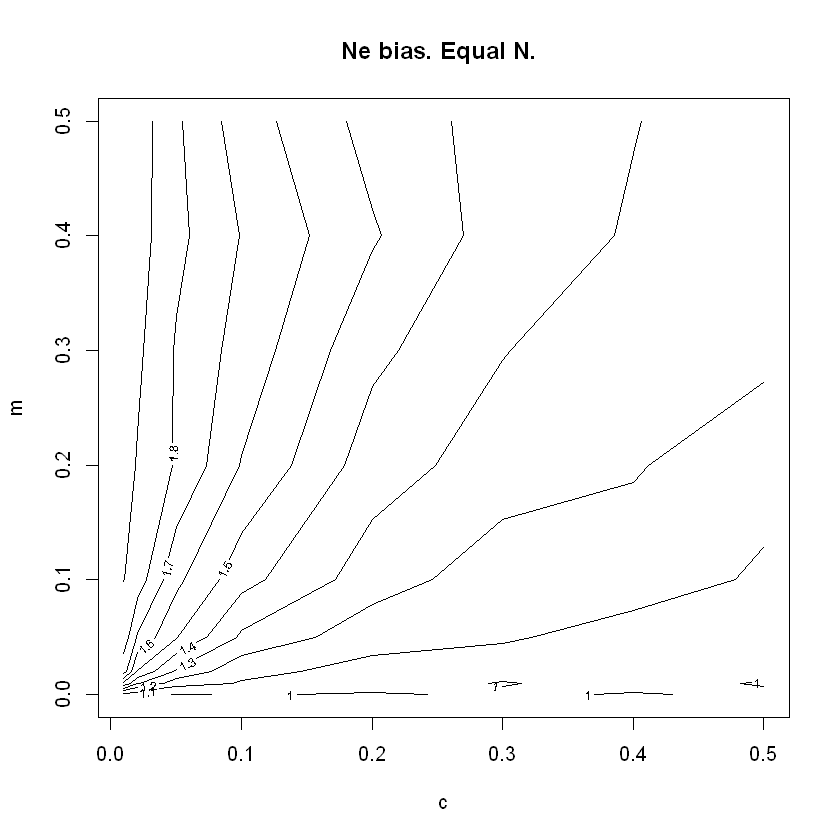

In [9]:
result_equal_N/1000
contour(c, m, result_equal_N/1000, xlab='c', ylab='m', main='Ne bias. Equal N. ')

1.0157789,1.680545,2.093096,2.690906,3.009335,3.285125,3.317428,3.488786,3.529834
1.0376116,1.430457,1.689860,2.252914,2.614186,2.965674,3.197310,3.231823,3.278482
1.0070713,1.173389,1.320743,1.630020,2.076847,2.467320,2.761303,2.905091,2.863204
1.0072430,1.121734,1.155504,1.367427,1.607550,1.949724,2.226408,2.319230,2.438275
1.0022522,1.057837,1.043166,1.160548,1.328288,1.499011,1.663427,1.792765,1.887557
0.9909707,1.013207,1.045911,1.112908,1.186247,1.347641,1.440636,1.517755,1.617504
0.9848452,1.023132,1.004735,1.068232,1.124617,1.256487,1.337890,1.424305,1.490018
0.9889927,1.016039,1.030123,1.065889,1.084355,1.151222,1.260051,1.382551,1.378026


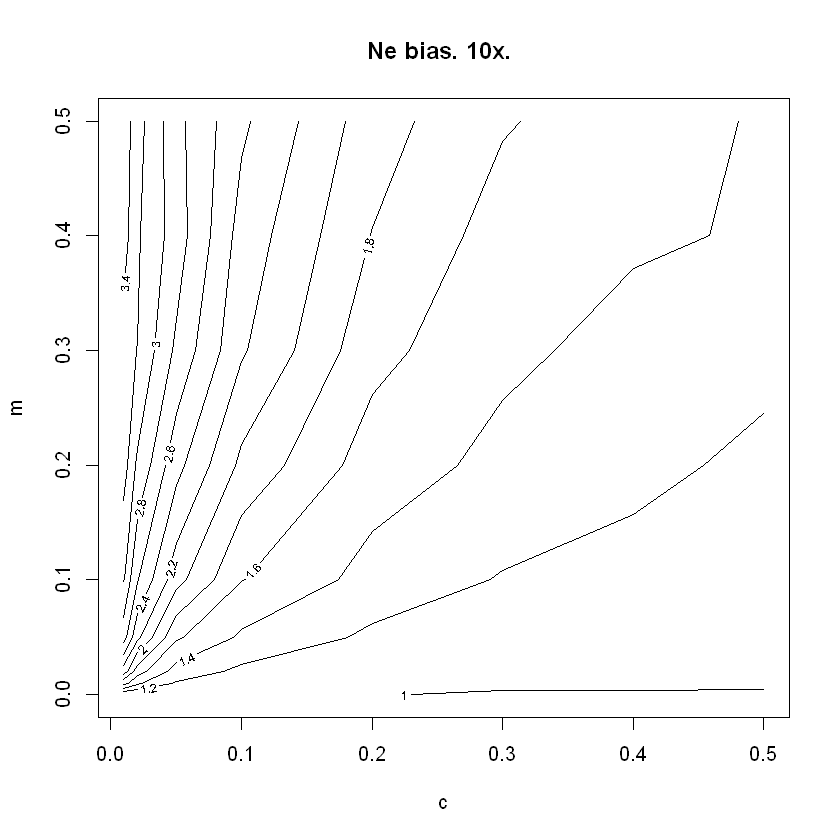

In [10]:
result_10x_N/1000
contour(c, m, result_10x_N/1000, xlab='c', ylab='m', main='Ne bias. 10x. ')

On these two contour plots, the value of 1 means there is no bias. It is trivial that there is no bias for $m=0$. Locus pairs with smaller $c$ have longer memory effect and contain information about historical events further backward in the past. They "capture" more migration events thus have larger bias. The maximum bias I found on the island-mainland case was about 3.5. 

Bascially they are similar to whatwhat Francesco had found (with minor numerical discrepancies?). Besides I did not observe any dips in bias for small $c$ values, a very minor point that we can live with. 

Now I just want to confirm that hese bias plots are invariant to $N_e$. 

0.9871893,1.507779,1.699655,1.852409,1.932119,1.981481,1.943577,2.088054,2.038601
0.9939697,1.265357,1.493764,1.629962,1.821019,1.877140,1.991501,1.921790,1.946571
1.0066317,1.184292,1.212912,1.493211,1.652524,1.741452,1.800457,1.801781,1.785147
1.0040824,1.111525,1.162221,1.299309,1.403901,1.596591,1.705010,1.682736,1.669540
1.0272788,1.060768,1.072726,1.177716,1.272653,1.398583,1.443264,1.481228,1.518769
0.9947731,0.975047,1.045027,1.063577,1.162266,1.220656,1.307418,1.337942,1.383709
0.9849715,0.995438,1.003932,1.078797,1.106843,1.193692,1.246026,1.310360,1.297065
1.0015635,1.012697,1.029170,1.035408,1.068355,1.161532,1.209473,1.235384,1.275676


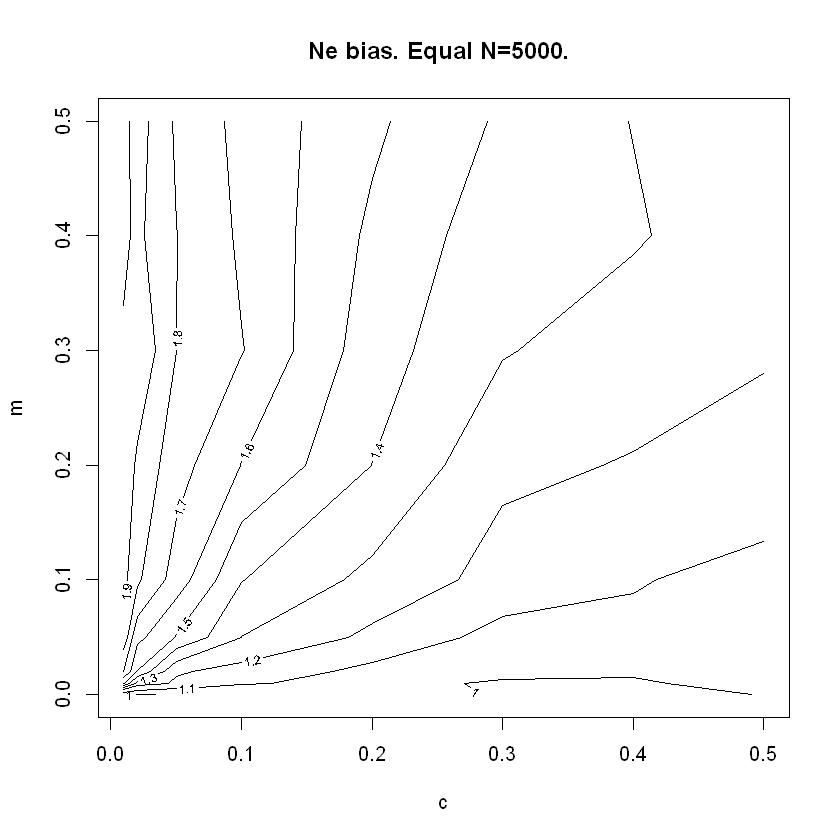

In [7]:
# I TEND TO HAVE DIFFERENT LENGTHS FOR c AND m TO AVOID CONFUSION
N_focal<-5000
c<-c(0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5)
m<-c(0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5)
result_equal<-matrix(NA, nrow=length(c), ncol=length(m))
result_equal_N<-matrix(NA, nrow=length(c), ncol=length(m))
cl<-makeCluster(40)
registerDoParallel(cl)
for (i in 1:length(c))
{
    for (j in 1:length(m))
    {
        t1<-round(2.4/c[i])
        t2<-ifelse(m[j]>0, round(2.4/m[j]), 10)
        t<-max(t1, t2)
        mig<-rep(m[j], t)
        N_focal<-rep(5000, t)
        temp_result<-foreach(k=1:5000, .combine='c') %dopar%
        {
            if (!is.loaded('allele_freq')) {dyn.load('cpp/aestivation1.dll')}
            temp<-sim_migration(N1=N_focal, N2=N_focal, m1=mig, m2=mig, c=c[i])$pop1_r2
            return(temp[t+1])
        }
        result_equal[i,j]<-mean(temp_result, na.rm=T)
        result_equal_N[i,j]<-eq_N(r2=result_equal[i,j], c=c[i])
    }
}
stopCluster(cl)
# PLOT
result_equal_N/5000
contour(c, m, result_equal_N/5000, xlab='c', ylab='m', main='Ne bias. Equal N=5000. ')

So the shape of the bias plots are the same for $N_e=1000$ and $N_e=5000$. 

#####

The next exercise look in Sved's between-population LD measure. 

Sved suggests a simple between-population LD measure which is the product (or covariance) of the two r's. If they are from two distinct populations, $E[r_i*r_j]=0$. I wonder if it is true. Below I simulate two migration rates: $m=0$ and $m=0.2$, and look at $r_i*r_j$ over time. 10000 independent simulations. 

In [ ]:
# JUST TRY TWO SCENARIOS. m=0 VS m=0.2. c=0.5 FIXED.
N_focal<-rep(1000, 50)
cl<-makeCluster(40)
registerDoParallel(cl)
result_mig0<-foreach(i=1:10000, .combine='rbind') %dopar%
   {
    if (!is.loaded('allele_freq')) {dyn.load('cpp/aestivation1.dll')}
    temp<-sim_migration(N1=N_focal, N2=N_focal, m1=rep(0, 50), m2=rep(0, 50), c=0.5)$pop12_rr
    return(temp)
   }
result_mig0.2<-foreach(i=1:10000, .combine='rbind') %dopar%
   {
    if (!is.loaded('allele_freq')) {dyn.load('cpp/aestivation1.dll')}
    temp<-sim_migration(N1=N_focal, N2=N_focal, m1=rep(0.5, 50), m2=rep(0.5, 50), c=0.5)$pop12_rr
    return(temp)
   }
stopCluster(cl)
dim(result_mig0)
dim(result_mig0.2)

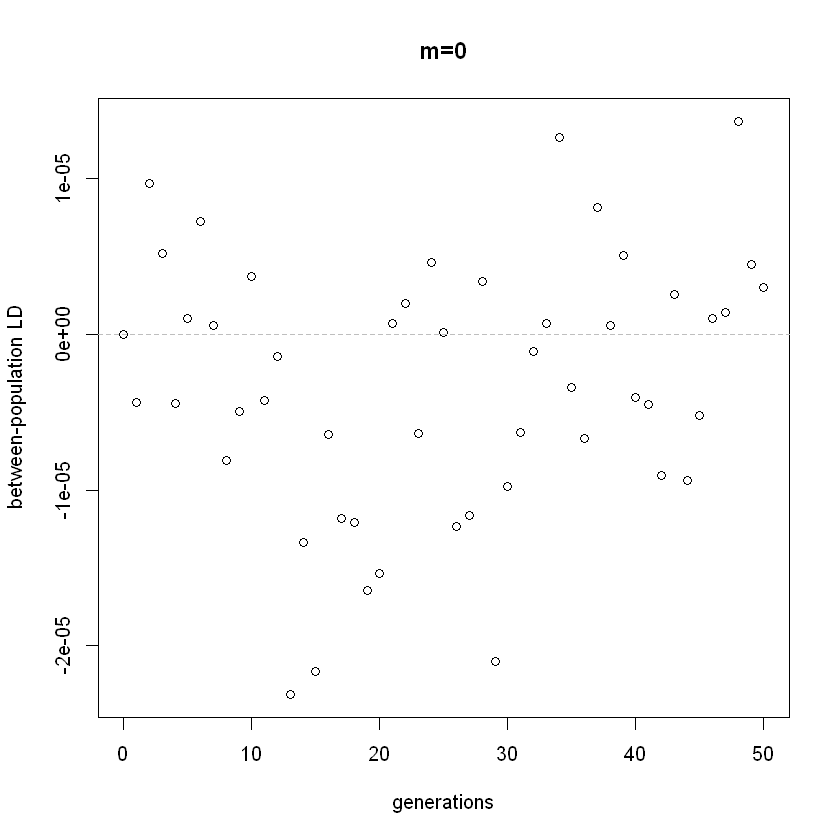

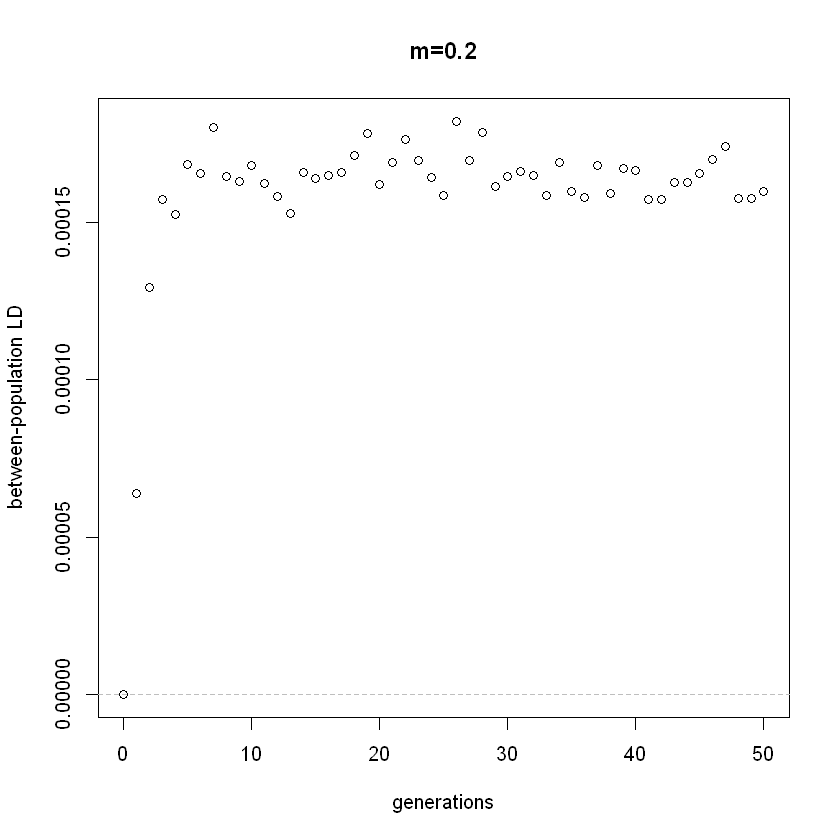

In [12]:
plot(0:50, apply(result_mig0, 2, mean), xlab='generations', ylab='between-population LD', main='m=0')
abline(h=0, col='grey', lty=2)
plot(0:50, apply(result_mig0.2, 2, mean), xlab='generations', ylab='between-population LD', main='m=0.2')
abline(h=0, col='grey', lty=2)

The first plot looks a white noise, with the average $r_i*r_j$ fluctuating around 0. The second plot (with $m=0.2$) has an equilibrium between-LD values. I expect the equilbrium $r_i*r_j$ values (and its rate to equilibrium) also depend on $c$. Sved might be *partially* correct that such simple product $r_i*r_j$ contains information about migration. 

There are other measures inspired by classical analysis of contingency tables. Usually there H0 is that the two populations are the same. I don't know what the advantages and disadvantages are for having different H0's. One thing I recommended doing is to verify these test statistics with simulations. For H0 (i.e. they are the same population), simply run single-population simulations, look at the final generation, and randomly assign it to the two populations and calculate your statistics. This should be your null distribution. Do the same for extreme H1 (i.e. with no migration at all) or anything in between. Hopefully they will be outliers when compared to the null. 

#####
[UPDATED]
Another thing I would like to mention is $E[D]$ or $E[r]$ in the simple two-locus two-allele case. Assume we have (A and a) allele on the first locus, and (B and b) allele on the second locus. Let $p_A$ and $p_B$ be the two marginal allele frequencies. When time goes, we expect that the proportion of haplotype AB will be close to $p_A*p_B$. We also define $D$ as the deviation between these two numbers. On average (i.e. if we pick many pairs of loci along the genome, calculate the D for each pair, take the average), $E[D]=0$. When we look at a pair loci individually, although it remains true that $E[D]=0$, the $D$ we calculate form the data is not necessarily 0. 

The second moment $var[D]=E[D^2]>0$. This is casued not only by the sampling variance (i.e. drawing random numbers from multinomial distribution), but also by genetic drift (finite $N_e$). Something you need to think about when designing test statistics. 

A bit more on the sampling issue. In practice we unavoidably have to deal with sampling error as we cannot survey all individuals from the population (analogy to population mean vs sample mean). Let's assume we have a population whose true haplotye frequencies are all 0.25, hence the true population LD is 0. Let's also consider the fact that we can only survey s individuals from the entire population (of size much greater than s), and we calculate our sample LD from this set of 2s haplotypes. We can happily use a multinomial distribution to model the sample haplotype counts. 

In [2]:
# TRUE HAPLOTYPE FREQ IS 0.25 EACH. WE SAMPLE s INDIVIDUALS (=2s HAPLOTYPES). MULTINOMIAL. 
# REPEAT 10000 TIMES. 
s<-30
sc<-rmultinom(10000, size=2*s, prob=c(0.25, 0.25, 0.25, 0.25))
# CALCULATE r2
r2<-(sc[1,]*sc[4,]-sc[2,]*sc[3,])^2/((sc[1,]+sc[2,])*(sc[3,]+sc[4,])*(sc[1,]+sc[3,])*(sc[2,]+sc[4,]))
mean(r2)

[1] 0.01697281

Even the underlying true LD is 0, the sample LD does not always have mean 0 (it's a biased estimator). This baseline or residual LD is caused by sampling. It is obvious that the residual LD diminishes with s, as shown below:

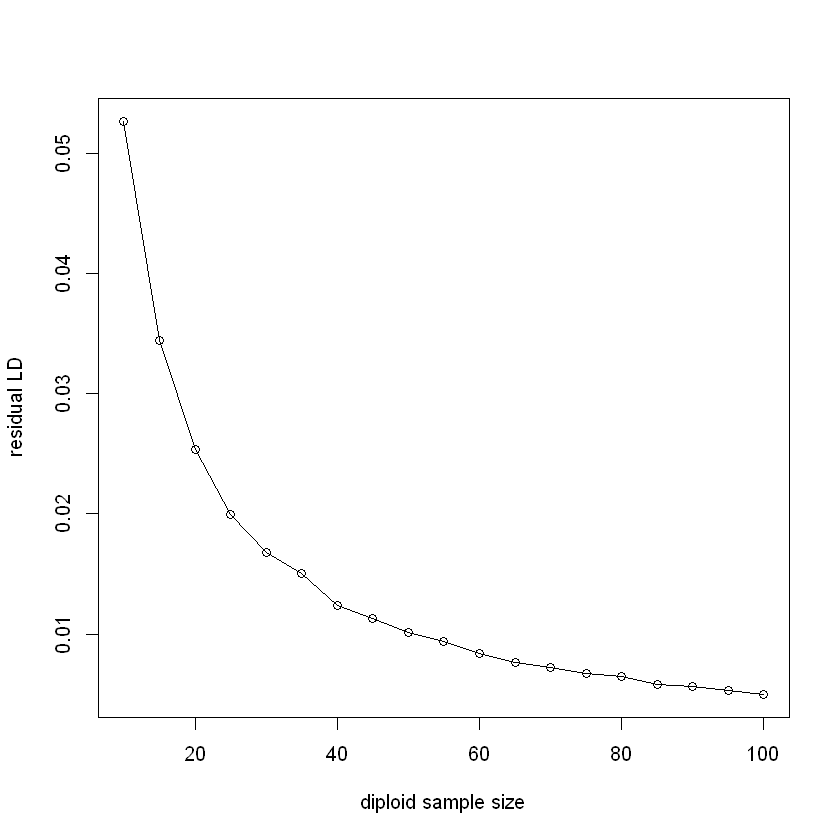

In [7]:
s<-seq(10, 100, 5)
r2<-s*0
for (i in 1:length(s))
    {
    sc<-rmultinom(10000, size=2*s[i], prob=c(0.25, 0.25, 0.25, 0.25))
    temp<-(sc[1,]*sc[4,]-sc[2,]*sc[3,])^2/((sc[1,]+sc[2,])*(sc[3,]+sc[4,])*(sc[1,]+sc[3,])*(sc[2,]+sc[4,]))
    r2[i]<-mean(temp, na.rm=T)
    }
plot(s, r2, xlab='diploid sample size', ylab='residual LD')
lines(s, r2)

Say, given a sample of 50 individuals, you are almost guaranteed to observe a minimum $r^2$ value of ~0.01 (the residual LD goes like 1/s). If your observed $r^2$ (average across many loci pairs) is larger than the residual LD, this could indicate the existence of other forces, one of which is genetic drift. Drift creates excess LD as it is essentially another layer of random sampling. When there is no drift (i.e. $N_e$ is infinitely large), the observed $r^2$ is close to the residual LD. 